# Think Green Investing 

## Data Preparation

In [241]:
# Initial imports
import os
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from datetime import datetime
import seaborn as sn
import matplotlib.pyplot as plt
import panel as pn
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

pn.extension('plotly')
import plotly.express as px
import hvplot.pandas
import os
from pathlib import Path
import plotly.graph_objects as go
import plotly.offline as pyo

%matplotlib inline

In [254]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed
from tensorflow import random



In [255]:
#intializing alpaca trade api
load_dotenv()
alpaca_api_key=os.getenv('ALPACA_API_KEY')
alpaca_secret_key=os.getenv('ALPACA_SECRET_KEY')
alpaca=tradeapi.REST(alpaca_api_key,alpaca_secret_key, api_version='v2')

In [256]:
#function that pulls tickers daily closing prices in the given time period using alpaca trade api, 
#intialization of the api is required before using.
#It returns a dataframe with the tickers, and closing prices as two level column structured datafram with index defined as date  

def get_tickers_data(tickers, start_date, end_date, timeframe):
    start_date = pd.Timestamp(start_date, tz = "America/New_York").isoformat()
    end_date = pd.Timestamp(end_date, tz = "America/New_York").isoformat()
    tickers_data_df = alpaca.get_bars(tickers, timeframe,start_date , end_date, adjustment = 'raw').df
    tickers_data_df.index = tickers_data_df.index.date
    tickers_data_df = tickers_data_df[['symbol', 'close']]
    tickers_data_list=[]
    for ticker in tickers:
        tickers_data_list.append(tickers_data_df[tickers_data_df['symbol']==ticker].drop('symbol', axis=1))
        
    clean_tickers_data = pd.concat(tickers_data_list,axis=1, keys=tickers)
    clean_tickers_data.columns=clean_tickers_data.columns.droplevel(-1)
    return clean_tickers_data

In [257]:
#defining the stocks in the solar energy portfolio form top performers in 2021 using mootley fool and investopedia. The companies are:
#1.First Solar (FSLR)
#2.Brookfield Renewable (BEPC) --> removed 
#3.Solar Edge Technologies (SEDG)
#4.Daqo New Energy Corp. (DQ)
#5.Canadian Solar INC (CSIQ)


# Set the ticker information
portfolio = ['FSLR' , 'SEDG', 'DQ', 'CSIQ', 'AQN']
indices = ['SPY']
timeframe='1Day'
tickers = portfolio + indices

Portfolio### Five Year Period Jan 2018 to April 2022

In [258]:
start_date = '2019-01-01'
end_date = '2022-06-15'

tickers_data = get_tickers_data(tickers, start_date, end_date, timeframe) 



In [259]:
#portfolio based on equal weight to each stock

asset = 1e5

tickers_data['Portfolio'] = asset + tickers_data.pct_change().cumsum().mean(axis = 1) *asset
tickers_data.dropna()

,FSLR,SEDG,DQ,CSIQ,AQN,SPY,Portfolio
2019-01-03,43.44,35.50,23.30,15.14,10.04,244.21,100069.279806
2019-01-04,46.32,37.25,24.74,16.37,10.10,252.39,105037.784697
2019-01-07,45.79,35.01,26.56,16.80,10.26,254.38,105904.159310
2019-01-08,46.23,35.00,26.05,17.13,10.38,256.77,106418.422666
2019-01-09,46.96,35.46,25.82,17.21,10.42,257.97,106973.447193
...,...,...,...,...,...,...,...
2022-06-09,69.83,291.67,60.99,34.02,14.30,401.44,257024.097360
2022-06-10,68.00,284.36,62.22,32.34,14.18,389.80,255059.567828
2022-06-13,63.13,264.34,58.43,30.16,13.82,375.00,249497.916309
2022-06-14,61.95,264.63,56.57,29.37,13.19,373.87,247427.573747


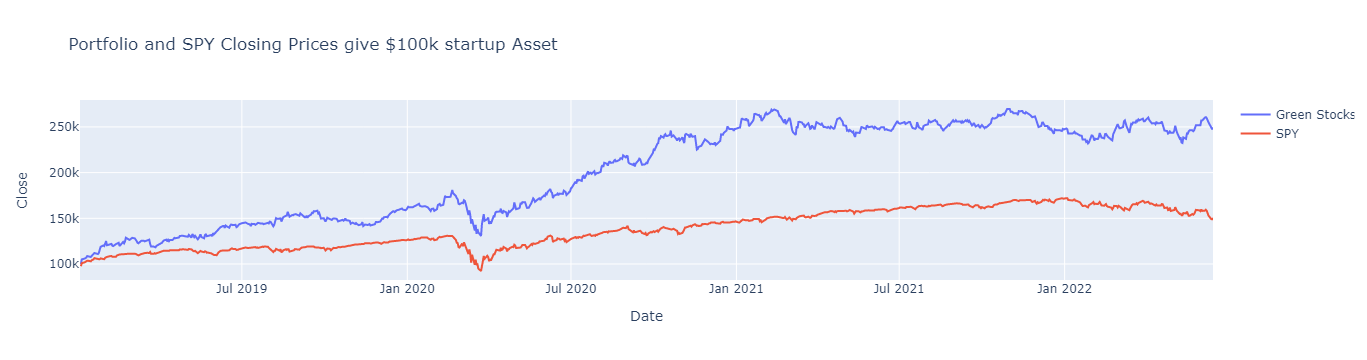

In [260]:

SPY_returns =asset + tickers_data["SPY"].pct_change().cumsum().dropna() * asset
SPY_returns.dropna()
trace1 = go.Scatter(
    x = tickers_data["Portfolio"].index,
    y = tickers_data["Portfolio"],
    mode = 'lines',
    name = 'Green Stocks'
)
trace2 = go.Scatter(
    x = SPY_returns.index,
    y = SPY_returns,
    mode = 'lines',
    name = 'SPY'
)

layout = go.Layout(
    title = "Portfolio and SPY Closing Prices give $100k startup Asset",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
data=[trace1, trace2]
#pyo.iplot(data, filename = 'basic-line', layout=layout)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [261]:

def predict_price(df_close, window, split_percent):
    close_data = df_close.values
    close_data = close_data.reshape((-1,1))
    split = int(split_percent*len(close_data))

    close_train = close_data[:split]
    close_test = close_data[split:]
    

   
    look_back = window

    train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
    test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    model = Sequential()
    model.add(
        LSTM(10,
            activation='relu',
            input_shape=(look_back,1))
        )
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    num_epochs = 25
    model.fit_generator(train_generator, epochs=num_epochs, verbose=1)
    prediction = model.predict_generator(test_generator)

    close_train = close_train.reshape((-1))
    close_test = close_test.reshape((-1))
    prediction = prediction.reshape((-1))
    return close_train, close_test, prediction, model 

In [266]:
window = 10
split_per= 0.8
seed(1)
random.set_seed(2)
close_train, close_test, prediction, model_p = predict_price(tickers_data['Portfolio'].dropna(), window, split_per)
seed(1)
random.set_seed(2)
close_train_spy, close_test_spy, prediction_spy, model_spy = predict_price(SPY_returns.dropna(), window, split_per)

Epoch 1/25


C:\Users\amany\Anaconda3\envs\alpacaenv\lib\site-packages\ipykernel_launcher.py:27: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



35/35 [==============================] - 1s 3ms/step - loss: 45552803840.0000
Epoch 2/25
35/35 [==============================] - 0s 3ms/step - loss: 32919648256.0000
Epoch 3/25
35/35 [==============================] - 0s 3ms/step - loss: 28827179008.0000
Epoch 4/25
35/35 [==============================] - 0s 3ms/step - loss: 25264773120.0000
Epoch 5/25
35/35 [==============================] - 0s 3ms/step - loss: 21795606528.0000
Epoch 6/25
35/35 [==============================] - 0s 3ms/step - loss: 19579396096.0000
Epoch 7/25
35/35 [==============================] - 0s 3ms/step - loss: 16698699776.0000
Epoch 8/25
35/35 [==============================] - 0s 3ms/step - loss: 13637040128.0000
Epoch 9/25
35/35 [==============================] - 0s 3ms/step - loss: 10809270272.0000
Epoch 10/25
35/35 [==============================] - 0s 3ms/step - loss: 8069420544.0000
Epoch 11/25
35/35 [==============================] - 0s 3ms/step - loss: 5667703296.0000
Epoch 12/25
35/35 [=============

C:\Users\amany\Anaconda3\envs\alpacaenv\lib\site-packages\ipykernel_launcher.py:28: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Epoch 1/25
35/35 [==============================] - 1s 3ms/step - loss: 21277433856.0000
Epoch 2/25
35/35 [==============================] - 0s 2ms/step - loss: 13953704960.0000
Epoch 3/25
35/35 [==============================] - 0s 3ms/step - loss: 11235718144.0000
Epoch 4/25
35/35 [==============================] - 0s 3ms/step - loss: 8281730560.0000
Epoch 5/25
35/35 [==============================] - 0s 3ms/step - loss: 4996775424.0000
Epoch 6/25
35/35 [==============================] - 0s 3ms/step - loss: 3320733184.0000
Epoch 7/25
35/35 [==============================] - 0s 3ms/step - loss: 2246397184.0000
Epoch 8/25
35/35 [==============================] - 0s 3ms/step - loss: 1347299200.0000
Epoch 9/25
35/35 [==============================] - 0s 3ms/step - loss: 736007808.0000
Epoch 10/25
35/35 [==============================] - 0s 3ms/step - loss: 1337219712.0000
Epoch 11/25
35/35 [==============================] - 0s 3ms/step - loss: 8628149248.0000
Epoch 12/25
35/35 [=========

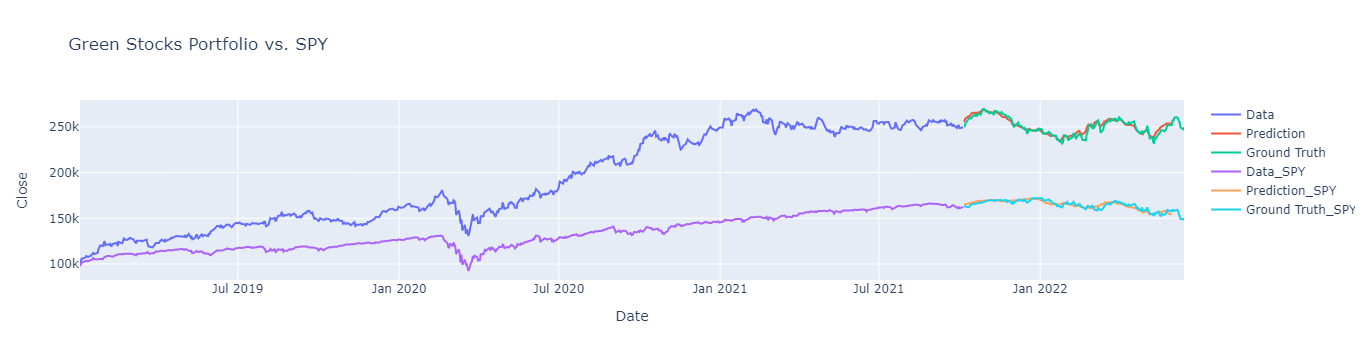

In [269]:
split = int(split_per*len(close_data))
date_train = tickers_data.index[:split].dropna()
date_test = tickers_data.index[split:].dropna()

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
trace4 = go.Scatter(
    x = date_train,
    y = close_train_spy,
    mode = 'lines',
    name = 'Data_SPY'
)
trace5 = go.Scatter(
    x = date_test,
    y = prediction_spy,
    mode = 'lines',
    name = 'Prediction_SPY'
)
trace6 = go.Scatter(
    x = date_test,
    y = close_test_spy,
    mode='lines',
    name = 'Ground Truth_SPY'
)
layout = go.Layout(
    title = "Green Stocks Portfolio vs. SPY",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
data=[trace1, trace2, trace3,trace4, trace5, trace6]
#pyo.iplot(data, filename = 'basic-line')
fig = go.Figure(data, layout=layout)
fig.show()


In [ ]:
    def predict(close_data, num_prediction, model, look_back):
            close_data = close_data.reshape((-1))
            prediction_list = close_data[-look_back:]
    
            for _ in range(num_prediction):
                x = prediction_list[-look_back:]
                x = x.reshape((1, look_back, 1))
                out = model.predict(x)[0][0]
                prediction_list = np.append(prediction_list, out)
            prediction_list = prediction_list[look_back-1:]
        
            return prediction_list
    
    def forecast_close(tickers_df, look_back, model,num_prediction):
        close_data = tickers_df.dropna().values.reshape((-1))
        forecast = predict(close_data, num_prediction, model, look_back)
        last_date = tickers_df.index.values[-1]
        forecast_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
        return forecast, forecast_dates

In [271]:
forecast, forecast_dates = forecast_close(tickers_data['Portfolio'], window, model_p,30)
forecast_spy, forecast_dates_spy = forecast_close(SPY_returns.dropna(), window, model_spy,30)

1/1 [==============================] - 0s 16ms/step


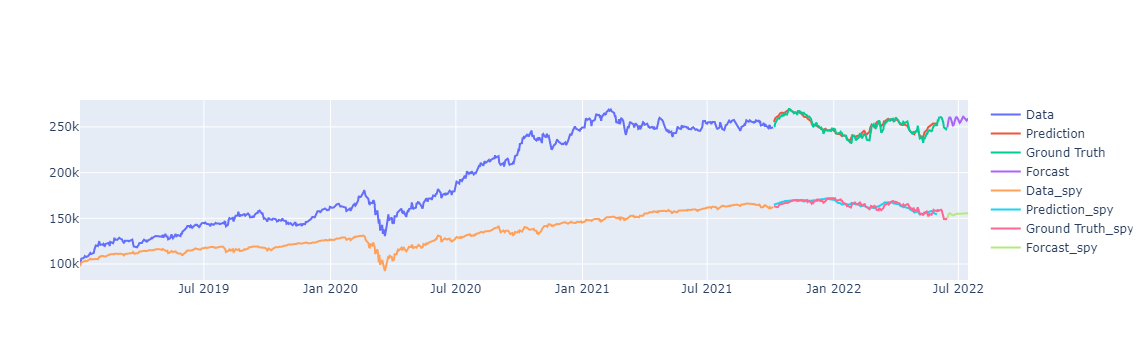

In [274]:

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode='lines',
    name = 'Forcast'
)
trace5 = go.Scatter(
    x = date_train,
    y = close_train_spy,
    mode = 'lines',
    name = 'Data_spy'
)
trace6 = go.Scatter(
    x = date_test,
    y = prediction_spy,
    mode = 'lines',
    name = 'Prediction_spy'
)
trace7 = go.Scatter(
    x = date_test,
    y = close_test_spy,
    mode='lines',
    name = 'Ground Truth_spy'
)
trace8 = go.Scatter(
    x = forecast_dates,
    y = forecast_spy,
    mode='lines',
    name = 'Forcast_spy'
)
layout = go.Layout(
    title = "Green Stocks Portfolio",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
data=[trace1, trace2, trace3, trace4,trace5, trace6, trace7, trace8]
pyo.iplot(data, filename = 'basic-line')